In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import spikeinterface.full as si

In [2]:
recording, gt_sorting = si.read_mearec('Neuropixels-128_rigid_uniform_homogeneous.h5')

In [3]:
fs = recording.sampling_frequency
sorting = gt_sorting.frame_slice(0, fs*60)
waveforms = si.extract_waveforms(recording, sorting, mode='memory', n_jobs=-1, overwrite=True, chunk_memory="10M")

extract waveforms shared_memory multi buffer:   0%|          | 0/984 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/984 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/984 [00:00<?, ?it/s]

In [4]:
import MEArec as mr
import numpy as np
rec = mr.load_recordings('Neuropixels-128_rigid_uniform_homogeneous.h5')
gt_positions = np.hstack((rec.template_locations[:, 50, 1:3], rec.template_locations[:, 50, 0][:, np.newaxis]))

In [5]:
spikes_positions = {}
unit_positions = {}
unit_times = {}

from spikeinterface.sortingcomponents.tools import get_prototype_spike

import time
for method in ['center_of_mass', 'monopolar_triangulation', 'grid_convolution', 'peak_channel']:
    if method == 'center_of_mass':
        for feature in ['ptp', 'energy', 'peak_voltage']:
            t_start = time.time() 
            title = f'CoM ({feature})'
            params = {'feature' : feature}
            unit_positions[title] = si.compute_unit_locations(waveforms, method=method, 
                                                           **params)
            spikes_positions[title] = si.compute_spike_locations(waveforms, method=method, 
                                                                          method_kwargs=params, n_jobs=-1,
                                                                        spike_retriver_kwargs={'channel_from_template' : False},
                                                                        chunk_memory="10M", outputs='by_unit')
            unit_times[title] = time.time() - t_start
    elif method == 'monopolar_triangulation':
        for feature in ['ptp', 'energy', 'peak_voltage']:
            t_start = time.time() 
            title = f'Monopolar ({feature})'
            params = {'enforce_decrease': False, 'feature' : feature}

            unit_positions[title] = si.compute_unit_locations(waveforms, method=method, 
                                                           **params)
            spikes_positions[title] = si.compute_spike_locations(waveforms, method=method, 
                                                                          method_kwargs=params, n_jobs=-1,
                                                                        spike_retriver_kwargs={'channel_from_template' : False},
                                                                        chunk_memory="10M", outputs='by_unit')
            unit_times[title] = time.time() - t_start
    elif method == 'grid_convolution':
        for feature in ['gaussian_2d', 'exponential_3d']:
            title = f'Grid ({feature})'
            params = {'weight_method': {'mode' : feature}}
            from spikeinterface.core.node_pipeline import SpikeRetriever
            from spikeinterface.core.template_tools import get_template_extremum_channel
            extremum_channel_inds = get_template_extremum_channel(waveforms, peak_sign="neg", outputs="index")
            spike_retriever = SpikeRetriever(
                        waveforms.recording, waveforms.sorting, extremum_channel_inds=extremum_channel_inds
                    )
            prototype = get_prototype_spike(waveforms.recording, spike_retriever.peaks, 0.5, 0.5, n_jobs=-1)
            
            t_start = time.time() 
            unit_positions[title] = si.compute_unit_locations(waveforms, method=method, 
                                                                   **params)
            params = {'prototype' : prototype, 'weight_method': {'mode' : feature}}
            spikes_positions[title] = si.compute_spike_locations(waveforms, method=method, 
                                                                              method_kwargs=params, n_jobs=-1,
                                                                            spike_retriver_kwargs={'channel_from_template' : False},
                                                                            chunk_memory="10M", outputs='by_unit')
            unit_times[title] = time.time() - t_start
    elif method == 'peak_channel':
        title = 'Peak Channel'
        params = {}
        from spikeinterface.core.template_tools import get_template_extremum_channel
        extremum_channel_inds = get_template_extremum_channel(waveforms, peak_sign="neg", outputs="index")
        positions = waveforms.recording.get_channel_locations()
        unit_positions[title] = np.array([positions[i] for i in extremum_channel_inds.values()])
        spikes_positions[title] = si.compute_spike_locations(waveforms, method=method, 
                                                                method_kwargs=params, n_jobs=-1,
                                                                spike_retriver_kwargs={'channel_from_template' : False}, 
                                                                chunk_memory="10M", outputs='by_unit')

localize peaks using center_of_mass:   0%|          | 0/984 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/984 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/984 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/984 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/984 [00:00<?, ?it/s]

localize peaks using monopolar_triangulation:   0%|          | 0/984 [00:00<?, ?it/s]

extract waveforms shared_memory mono buffer:   0%|          | 0/600 [00:00<?, ?it/s]

localize peaks using grid_convolution:   0%|          | 0/984 [00:00<?, ?it/s]

extract waveforms shared_memory mono buffer:   0%|          | 0/600 [00:00<?, ?it/s]

localize peaks using grid_convolution:   0%|          | 0/984 [00:00<?, ?it/s]

localize peaks using peak_channel:   0%|          | 0/984 [00:00<?, ?it/s]

In [6]:
colors = {}

import matplotlib as mpl

cmap = mpl.cm.tab20c
norm = mpl.colors.Normalize(vmin=0, vmax=1)

for value, key in zip([0,0.05,0.1,0.4,0.45,0.5, 0.6, 0.65, 0.9], unit_positions.keys()):    
    colors[key] = mpl.cm.ScalarMappable(norm=norm, cmap=cmap).to_rgba(value)

dict_keys(['CoM (ptp)', 'CoM (energy)', 'CoM (peak_voltage)', 'Monopolar (ptp)', 'Monopolar (energy)', 'Monopolar (peak_voltage)', 'Grid (gaussian_2d)', 'Grid (exponential_3d)'])


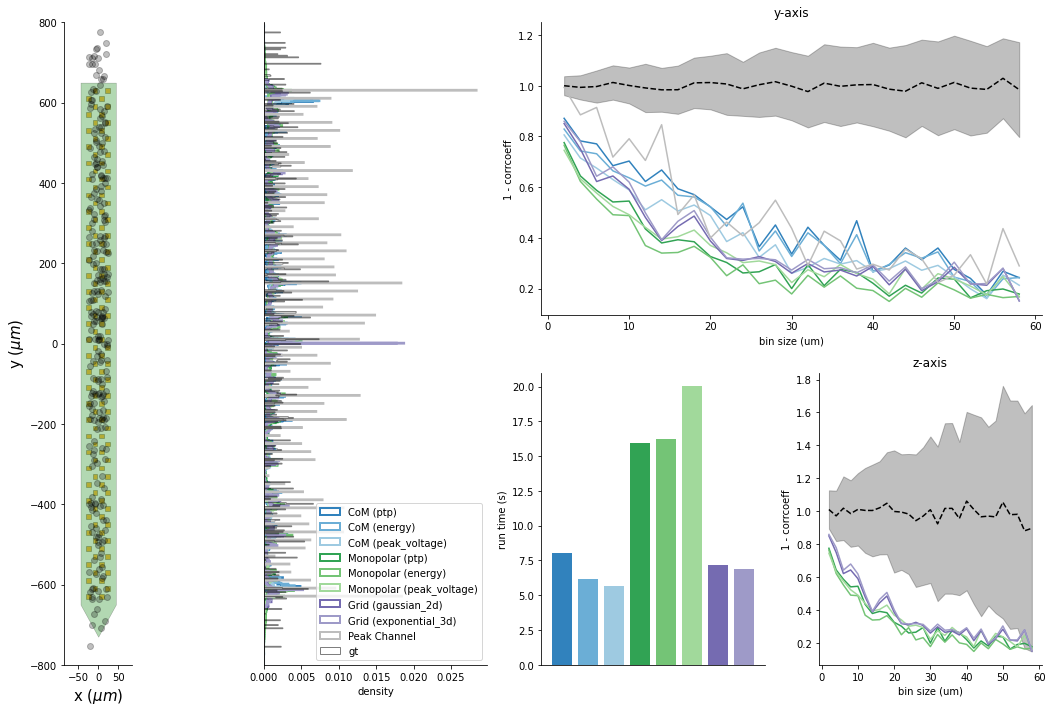

In [7]:
import pylab as plt
import scipy

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)


ax = fig.add_subplot(gs[:, 0])

si.plot_probe_map(recording, ax=ax)


bin_sizes = np.arange(2, 60, 2)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)

ax.scatter(gt_positions[:,0], gt_positions[:,1], alpha=0.25, color='k')
plt.tight_layout()
ax.set_ylim(-800, 800)

gt_index = gt_sorting.to_spike_vector()['unit_index']


histograms = {}
z_histograms = {}

ax = fig.add_subplot(gs[:, 1])

for key, value in spikes_positions.items():
    positions = np.zeros(0)
    for item in value[0].values():
        positions = np.concatenate((positions, item['y']))
    
    histograms[key] = {}
    for bin_size in bin_sizes:
        bins = np.arange(-800, 800, bin_size) 
        x, y = np.histogram(positions, bins=bins)  
        histograms[key][bin_size] = x
        #ax.plot(x, label=key)
        if bin_size == 2:
            ax.hist(positions, bins=bins, orientation='horizontal', 
                    histtype='step', lw=2, label=key, color=colors[key], density=True)

    if key.find('Grid') > -1 or key.find('Monopolar') > -1:

        z_positions = np.zeros(0)
        for item in value[0].values():
            z_positions = np.concatenate((z_positions, item['z']))
    
        z_histograms[key] = {}
        for bin_size in bin_sizes:
            bins = np.arange(0, 200, bin_size) 
            x, y = np.histogram(positions, bins=bins)  
            z_histograms[key][bin_size] = x
            #ax.plot(x, label=key)
    

histograms['gt'] = {}
z_histograms['gt'] = {}

for bin_size in bin_sizes:
    bins = np.arange(-800, 800, bin_size) 
    x, y = np.histogram(gt_positions[gt_index, 1], bins=bins)
    histograms['gt'][bin_size] = x
    #ax.plot(x, label='gt', alpha=0.5)
    if bin_size == 2:
        ax.hist(gt_positions[gt_index, 1], bins=bins, orientation='horizontal', 
            alpha=0.5, histtype='step', label='gt', color='k', density=True)

    bins = np.arange(0, 200, bin_size) 
    x, y = np.histogram(gt_positions[gt_index, 2], bins=bins)
    z_histograms['gt'][bin_size] = x
        
#ax.set_xscale('log')
#random_positions = -800 + 1600 * np.random.rand(len(gt_index))
#x, y = np.histogram(random_positions, bins=np.linspace(-800, 800, 1000), density=False)  
#histograms['control'] = x

ax.set_xlabel('density')
ax.set_yticks([], [])
ax.legend()


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#axes[1].hist(gt_positions[gt_index, 1] , bins=np.linspace(-800, 800, 1000), orientation='horizontal', label='gt', density=True)  
ax.set_ylim(-800, 800)


def bhattacharyya(h1, h2):
  '''Calculates the Byattacharyya distance of two histograms.'''

  def normalize(h):
    return h / np.sum(h)

  return 1 - np.sum(np.sqrt(np.multiply(normalize(h1), normalize(h2))))



nb_control = 100

distances = ['1 - corrcoeff']#, 'wasserstein', 'bhattacharyya']
results = {}
z_results = {}

    
for key in spikes_positions.keys():
    results[key] = {}
    z_results[key] = {}
    for bin_size in bin_sizes:
        source = histograms['gt'][bin_size]
        target = histograms[key][bin_size]
        results[key][bin_size] = {}
                
        for d in distances:
            if d == '1 - corrcoeff':
                value = 1 - np.corrcoef(source, target)[0, 1]
            elif d == 'wasserstein':
                value = scipy.stats.wasserstein_distance(source, target)
            elif d == 'bhattacharyya':
                value = bhattacharyya(source, target)
            elif d == 'correlation':
                a = (source - np.mean(source)) / (np.std(source) * len(source))
                b = (target - np.mean(target)) / (np.std(target))
                correlation = np.correlate(a, b, 'full')
                value = correlation.max()
            
            results[key][bin_size][d] = value

        if key.find('Grid') > -1 or key.find('Monopolar') > -1:
            source_z = z_histograms['gt'][bin_size]
            target_z = z_histograms[key][bin_size]
            z_results[key][bin_size] = {}
            for d in distances:
                if d == '1 - corrcoeff':
                    value = 1 - np.corrcoef(source, target)[0, 1]
                elif d == 'wasserstein':
                    value = scipy.stats.wasserstein_distance(source, target)
                elif d == 'bhattacharyya':
                    value = bhattacharyya(source, target)
                elif d == 'correlation':
                    a = (source - np.mean(source)) / (np.std(source) * len(source))
                    b = (target - np.mean(target)) / (np.std(target))
                    correlation = np.correlate(a, b, 'full')
                    value = correlation.max()

                z_results[key][bin_size][d] = value
            
nb_control = 100

noise_levels = {}
z_noise_levels = {}

for bin_size in bin_sizes:
    noise_levels[bin_size] = {}
    z_noise_levels[bin_size] = {}
    source = histograms['gt'][bin_size]
    z_source = z_histograms['gt'][bin_size]
    bins = np.arange(-800, 800, bin_size) 
    z_bins = np.arange(0, 200, bin_size)
    for d in distances:
        noise_levels[bin_size][d] = []
        z_noise_levels[bin_size][d] = []
        for j in range(nb_control):
            #ax.set_xscale('log')
            random_positions = -800 + 1600 * np.random.rand(len(gt_index))
            x, y = np.histogram(random_positions, bins=bins)  
            target = x
            if d == '1 - corrcoeff':
                value = 1 - np.corrcoef(source, target)[0, 1]
            elif d == 'wasserstein':
                value = scipy.stats.wasserstein_distance(source, target)
            elif d == 'bhattacharyya':
                value = bhattacharyya(source, target)
            elif d == 'correlation':
                a = (source - np.mean(source)) / (np.std(source) * len(source))
                b = (target - np.mean(target)) / (np.std(target))
                correlation = np.correlate(a, b, 'full')
                value = correlation.max()
            
            noise_levels[bin_size][d] += [value]
            
            z_random_positions = 200 * np.random.rand(len(gt_index))
            x, y = np.histogram(z_random_positions, bins=z_bins)  
            target = x
            if d == '1 - corrcoeff':
                value = 1 - np.corrcoef(z_source, target)[0, 1]
            elif d == 'wasserstein':
                value = scipy.stats.wasserstein_distance(z_source, target)
            elif d == 'bhattacharyya':
                value = bhattacharyya(z_source, target)
            elif d == 'correlation':
                a = (source - np.mean(z_source)) / (np.std(z_source) * len(z_source))
                b = (target - np.mean(target)) / (np.std(target))
                correlation = np.correlate(a, b, 'full')
                value = correlation.max()
            
            z_noise_levels[bin_size][d] += [value]
             
ax.legend()

axes = [fig.add_subplot(gs[0, 2:])]
        #fig.add_subplot(gs[2, 2:])]

for i, title in enumerate(spikes_positions.keys()):
    data = []
    for bin_size in bin_sizes:
        data += [results[title][bin_size]['1 - corrcoeff']]
    axes[-1].plot(bin_sizes, data, color=colors[title])
    axes[-1].spines['right'].set_visible(False)
    axes[-1].spines['top'].set_visible(False)

data_m = []
data_s = []
for bin_size in bin_sizes:
    data_m += [np.mean(noise_levels[bin_size]['1 - corrcoeff'])]
    data_s += [np.std(noise_levels[bin_size]['1 - corrcoeff'])]
axes[-1].plot(bin_sizes, data_m, 'k--')
data_m = np.array(data_m)
data_s = np.array(data_s)
y1 = data_m-data_s
y2 = data_m+data_s
axes[-1].fill_between(bin_sizes, y1, y2, color='k', alpha=0.25)
axes[-1].set_xlabel('bin size (um)')
axes[-1].set_ylabel('1 - corrcoeff')
axes[-1].set_title('y-axis')


ax = fig.add_subplot(gs[1, 2])
print(unit_times.keys())
for i, title in enumerate(unit_times.keys()):
    ax.bar([i], [unit_times[title]], color=colors[title])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([], [])
ax.set_ylabel('run time (s)')

ax = fig.add_subplot(gs[1, 3])
for i, title in enumerate(spikes_positions.keys()):
    data = []
    if title.find('Grid') > -1 or title.find('Monopolar') > -1:
        for bin_size in bin_sizes:
            data += [z_results[title][bin_size]['1 - corrcoeff']]
        ax.plot(bin_sizes, data, color=colors[title])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
ax.set_title('z-axis')

data_m = []
data_s = []
for bin_size in bin_sizes:
    data_m += [np.mean(z_noise_levels[bin_size]['1 - corrcoeff'])]
    data_s += [np.std(z_noise_levels[bin_size]['1 - corrcoeff'])]
ax.plot(bin_sizes, data_m, 'k--')
data_m = np.array(data_m)
data_s = np.array(data_s)
y1 = data_m-data_s
y2 = data_m+data_s
ax.fill_between(bin_sizes, y1, y2, color='k', alpha=0.25)
ax.set_xlabel('bin size (um)')
ax.set_ylabel('1 - corrcoeff')


plt.tight_layout()
plt.savefig('histogram.pdf')

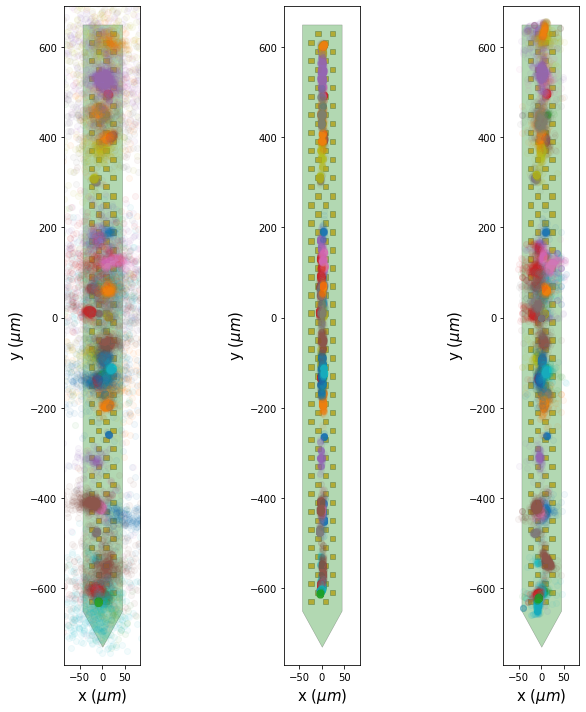

In [8]:
import pylab as plt
fig, axes = plt.subplots(1, 3, figsize=(10,10))
for count, method in enumerate(['Monopolar (ptp)', 'CoM (ptp)', 'Grid (exponential_3d)']):
    si.plot_probe_map(recording, ax=axes[count])
    for unit_id in waveforms.unit_ids[::5]:
        data = spikes_positions[method][0][unit_id]
        axes[count].scatter(data['x'], data['y'], alpha=0.05)
fig.tight_layout()


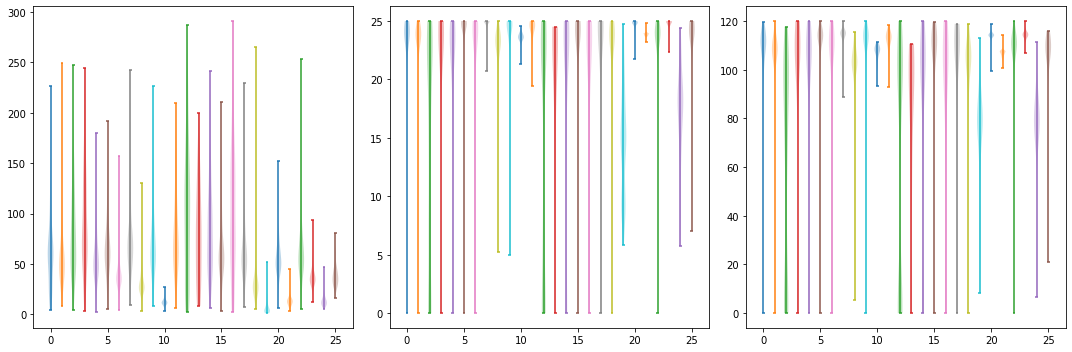

In [9]:
import pylab as plt
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for count, method in enumerate(['Monopolar (ptp)', 'Grid (gaussian_2d)', 'Grid (exponential_3d)']):
    #si.plot_probe_map(recording, ax=axes[count])
    for c, unit_id in enumerate(waveforms.unit_ids[::10]):
        axes[count].violinplot(spikes_positions[method][0][unit_id]['z'], [c])
fig.tight_layout()

0.4009533578610768
0.9261184566747378
0.9200986928801379


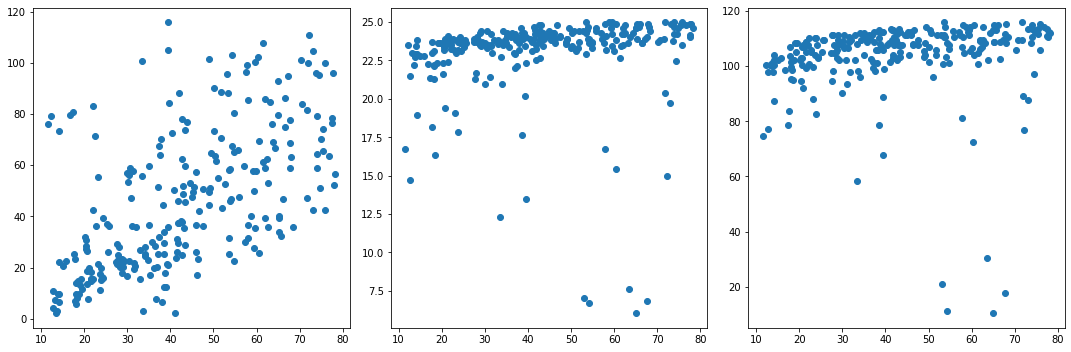

In [11]:
import pylab as plt
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for count, method in enumerate(['Monopolar (ptp)', 'Grid (gaussian_2d)', 'Grid (exponential_3d)']):
    #si.plot_probe_map(recording, ax=axes[count])
    res = []
    for c, unit_id in enumerate(waveforms.unit_ids):
        res += [np.median(spikes_positions[method][0][unit_id]['z'])]
    axes[count].scatter(gt_positions[:, 2], res)        
    print(1 - np.corrcoef(gt_positions[:, 2], res)[0,1])
fig.tight_layout()

[autoreload of spikeinterface.postprocessing.unit_localization failed: Traceback (most recent call last):
  File "/home/cure/anaconda3/envs/circus/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/cure/anaconda3/envs/circus/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/home/cure/anaconda3/envs/circus/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/media/cure/Secondary/pierre/softwares/spikeinterface/src/spikeinterface/postprocessing/unit_localization.py", line 95, in <module>
    WaveformExtractor.register_extension(UnitLocationsCalculator)
  File "/media

Text(0, 0.5, '1 - corrcoeff')

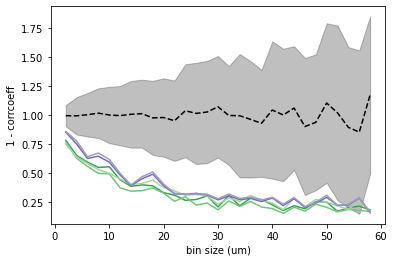

In [29]:
#distances = ['1 - corrcoeff', 'wasserstein', 'bhattacharyya']
d = "1 - corrcoeff"
for i, title in enumerate(spikes_positions.keys()):
    data = []
    if title.find('Grid') > -1 or title.find('Monopolar') > -1:
        for bin_size in bin_sizes:
            data += [z_results[title][bin_size][d]]
        plt.plot(bin_sizes, data, color=colors[title])

data_m = []
data_s = []
for bin_size in bin_sizes:
    data_m += [np.mean(z_noise_levels[bin_size][d])]
    data_s += [np.std(z_noise_levels[bin_size][d])]
plt.plot(bin_sizes, data_m, 'k--')
data_m = np.array(data_m)
data_s = np.array(data_s)
y1 = data_m-data_s
y2 = data_m+data_s
plt.fill_between(bin_sizes, y1, y2, color='k', alpha=0.25)
plt.xlabel('bin size (um)')
plt.ylabel(d)

Text(0, 0.5, '1 - corrcoeff')

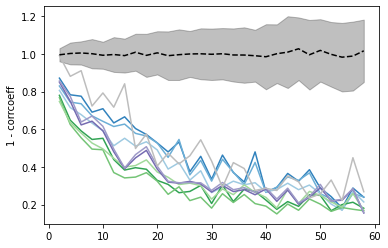

In [30]:
#distances = ['1 - corrcoeff', 'wasserstein', 'bhattacharyya']
d = "1 - corrcoeff"
for i, title in enumerate(spikes_positions.keys()):
    data = []
    for bin_size in bin_sizes:
        data += [results[title][bin_size][d]]
    plt.plot(bin_sizes, data, color=colors[title])

data_m = []
data_s = []
for bin_size in bin_sizes:
    data_m += [np.mean(noise_levels[bin_size][d])]
    data_s += [np.std(noise_levels[bin_size][d])]
plt.plot(bin_sizes, data_m, 'k--')
data_m = np.array(data_m)
data_s = np.array(data_s)
y1 = data_m-data_s
y2 = data_m+data_s
plt.fill_between(bin_sizes, y1, y2, color='k', alpha=0.25)
plt.ylabel(d)

In [ ]:
spikes_positions['Grid']